In [0]:
!pip install xgboost
!pip install lightgbm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import warnings
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, spearmanr, stats, kruskal, f_oneway
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer, MissingIndicator
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:
types_y = {'row_id':'int64', 'rate_spread': 'float64'}
#types_x = {'row_id':'int64', 'loan_type': 'object', 'property_type':'object',
#           'loan_purpose':'object' , 'occupancy': 'categorical', 'loan_amount': 'float64', 
#           'preapproval': 'category', 'msa_md': 'category' , 'state_code' : 'category', 'county_code':'category',
#          'applicant_ethnicity':'category', 'applicant_race':'category', 'applicant_sex':'category',
#           'lender': 'category'}
train_values = pd.read_csv('/content/drive/My Drive/Final Capstone/train_values.csv')
train_labels = pd.read_csv('/content/drive/My Drive/Final Capstone/train_labels_abiUmgM.csv', dtype = types_y)
test_values = pd.read_csv('/content/drive/My Drive/Final Capstone/test_values.csv' ) 

FileNotFoundError: ignored

In [0]:
test_values.head(5)

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,1,2,1,1,46.0,3,262,37,83,1,5,2,50.0,10761.0,43.415,61732.0,100.000,2900.0,3603.0,1119,False
1,1,1,1,3,1,170.0,3,282,11,267,2,5,1,155.0,2285.0,20.115,50373.0,100.000,539.0,873.0,4216,False
2,2,1,1,1,1,174.0,3,274,12,162,1,5,1,102.0,7765.0,78.621,75175.0,54.165,1559.0,1712.0,2467,False
3,3,1,1,1,2,116.0,2,254,37,282,2,5,1,51.0,3387.0,96.208,48677.0,74.476,938.0,784.0,2773,True
4,4,1,1,3,1,108.0,3,194,41,17,2,5,1,88.0,3106.0,6.370,68070.0,100.000,1119.0,1301.0,3110,False


In [0]:
data = pd.merge(train_values, train_labels, on = 'row_id')
data = data.astype({'loan_type': 'category', 'property_type':'category', 'loan_purpose':'category', 
               'occupancy':'category', 'preapproval':'category', 'msa_md':'category', 'state_code':'category',
                'county_code':'category', 'applicant_ethnicity':'category', 'applicant_race':'category',
               'applicant_sex':'category', 'lender':'category', 'co_applicant':'category'})
data.dtypes

row_id                               int64
loan_type                         category
property_type                     category
loan_purpose                      category
occupancy                         category
loan_amount                        float64
preapproval                       category
msa_md                            category
state_code                        category
county_code                       category
applicant_ethnicity               category
applicant_race                    category
applicant_sex                     category
applicant_income                   float64
population                         float64
minority_population_pct            float64
ffiecmedian_family_income          float64
tract_to_msa_md_income_pct         float64
number_of_owner-occupied_units     float64
number_of_1_to_4_family_units      float64
lender                            category
co_applicant                      category
rate_spread                        float64
dtype: obje

In [0]:
data.describe()

,row_id,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,rate_spread
count,200000.000000,200000.000000,189292.000000,198005.000000,198005.000000,198015.000000,197977.000000,197988.000000,197984.000000,200000.000000
mean,99999.500000,142.574940,73.617902,5391.099099,34.238640,64595.355801,89.283022,1402.872401,1927.336618,1.979110
std,57735.171256,142.559487,105.696934,2669.028807,27.930882,12724.514485,15.059223,706.880410,886.576586,1.656809
min,0.000000,1.000000,1.000000,7.000000,0.326000,17860.000000,6.193000,3.000000,6.000000,1.000000
25%,49999.750000,67.000000,39.000000,3717.000000,10.928000,56654.000000,81.648000,932.000000,1344.000000,1.000000
50%,99999.500000,116.000000,56.000000,4959.000000,25.996000,63485.000000,98.959000,1304.000000,1799.000000,1.000000
75%,149999.250000,179.000000,83.000000,6470.000000,52.000000,71238.000000,100.000000,1742.000000,2353.000000,2.000000
max,199999.000000,11104.000000,10042.000000,34126.000000,100.000000,125095.000000,100.000000,8747.000000,13615.000000,99.000000


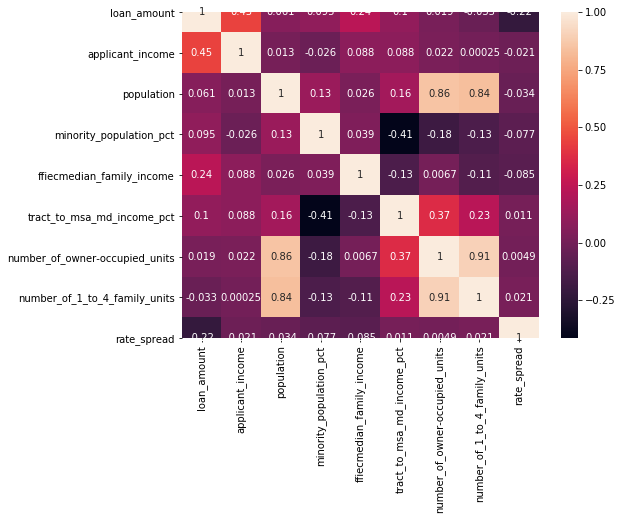

In [0]:
f = plt.figure(figsize = (8,6))
sns.heatmap(data.drop(['row_id'], axis = 1).corr(), annot = True)

In [0]:
# Check null value
for c in data.columns:
       print('Any Missing Values in ' + str(c) + ':\n' + str(data[c].isna().any()))

Any Missing Values in row_id:
False
Any Missing Values in loan_type:
False
Any Missing Values in property_type:
False
Any Missing Values in loan_purpose:
False
Any Missing Values in occupancy:
False
Any Missing Values in loan_amount:
False
Any Missing Values in preapproval:
False
Any Missing Values in msa_md:
False
Any Missing Values in state_code:
False
Any Missing Values in county_code:
False
Any Missing Values in applicant_ethnicity:
False
Any Missing Values in applicant_race:
False
Any Missing Values in applicant_sex:
False
Any Missing Values in applicant_income:
True
Any Missing Values in population:
True
Any Missing Values in minority_population_pct:
True
Any Missing Values in ffiecmedian_family_income:
True
Any Missing Values in tract_to_msa_md_income_pct:
True
Any Missing Values in number_of_owner-occupied_units:
True
Any Missing Values in number_of_1_to_4_family_units:
True
Any Missing Values in lender:
False
Any Missing Values in co_applicant:
False
Any Missing Values in rate

In [0]:
for c in data.columns:
       print('Any Values = -1 in ' + str(c) + ': ' + str((data[c] == -1).any()))

Any Values = -1 in row_id: False
Any Values = -1 in loan_type: False
Any Values = -1 in property_type: False
Any Values = -1 in loan_purpose: False
Any Values = -1 in occupancy: False
Any Values = -1 in loan_amount: False
Any Values = -1 in preapproval: False
Any Values = -1 in msa_md: False
Any Values = -1 in state_code: True
Any Values = -1 in county_code: False
Any Values = -1 in applicant_ethnicity: False
Any Values = -1 in applicant_race: False
Any Values = -1 in applicant_sex: False
Any Values = -1 in applicant_income: False
Any Values = -1 in population: False
Any Values = -1 in minority_population_pct: False
Any Values = -1 in ffiecmedian_family_income: False
Any Values = -1 in tract_to_msa_md_income_pct: False
Any Values = -1 in number_of_owner-occupied_units: False
Any Values = -1 in number_of_1_to_4_family_units: False
Any Values = -1 in lender: False
Any Values = -1 in co_applicant: False
Any Values = -1 in rate_spread: False


In [0]:
cols = ['applicant_income', 'population', 'minority_population_pct', 
        'ffiecmedian_family_income', 'tract_to_msa_md_income_pct', 
        'number_of_owner-occupied_units', 'number_of_1_to_4_family_units']
for c in cols: 
      print(str(c) + ':' + str(data[c].isna().sum()))

applicant_income:10708
population:1995
minority_population_pct:1995
ffiecmedian_family_income:1985
tract_to_msa_md_income_pct:2023
number_of_owner-occupied_units:2012
number_of_1_to_4_family_units:2016


In [0]:
for c in test_values: 
      print(str(c) + ':' + str(test_values[c].isna().sum()))

row_id:0
loan_type:0
property_type:0
loan_purpose:0
occupancy:0
loan_amount:0
preapproval:0
msa_md:0
state_code:0
county_code:0
applicant_ethnicity:0
applicant_race:0
applicant_sex:0
applicant_income:10371
population:1918
minority_population_pct:1920
ffiecmedian_family_income:1905
tract_to_msa_md_income_pct:1946
number_of_owner-occupied_units:1933
number_of_1_to_4_family_units:1933
lender:0
co_applicant:0


In [0]:
for c in cols:
    temp = data[data[c].notna()]
    data[c] = data[c].fillna(temp[c].mean())

In [0]:
df = data.drop(['row_id','lender','msa_md',
                'state_code','applicant_ethnicity', 
                'preapproval', 'applicant_race', 'occupancy'
                ], axis = 1)
df.columns

Index(['loan_type', 'property_type', 'loan_purpose', 'loan_amount',
       'county_code', 'applicant_sex', 'applicant_income', 'population',
       'minority_population_pct', 'ffiecmedian_family_income',
       'tract_to_msa_md_income_pct', 'number_of_owner-occupied_units',
       'number_of_1_to_4_family_units', 'co_applicant', 'rate_spread'],
      dtype='object')

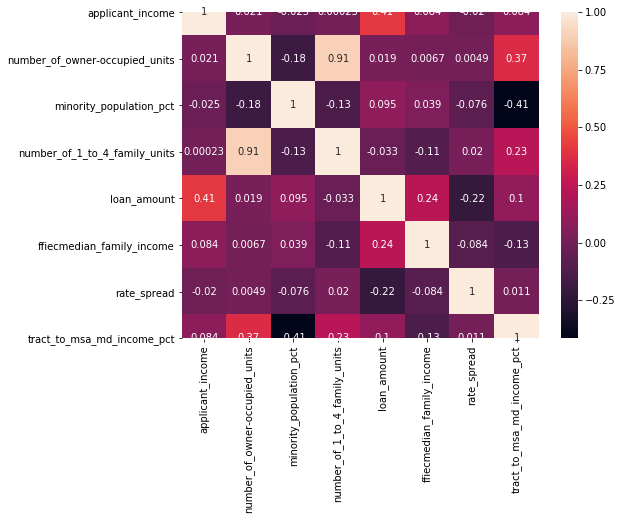

In [0]:
f = plt.figure(figsize = (8,6))
sad1 = data.loc[:,{'loan_amount','ffiecmedian_family_income','tract_to_msa_md_income_pct', 
                   'number_of_owner-occupied_units','applicant_income', 'rate_spread', 
                   'number_of_1_to_4_family_units','minority_population_pct'}]
sns.heatmap(sad1.corr(), annot =  True)

In [0]:
cat_feature = df.select_dtypes(exclude=['float64'])
cat_feature_one_hot = pd.get_dummies(cat_feature)
cat_feature_one_hot.head()

,loan_type_1,loan_type_2,loan_type_3,loan_type_4,property_type_1,property_type_2,property_type_3,loan_purpose_1,loan_purpose_2,loan_purpose_3,county_code_0,county_code_1,county_code_2,county_code_3,county_code_4,county_code_5,county_code_6,county_code_7,county_code_8,county_code_9,county_code_10,county_code_11,county_code_12,county_code_13,county_code_14,county_code_15,county_code_16,county_code_17,county_code_18,county_code_19,county_code_20,county_code_21,county_code_22,county_code_23,county_code_24,county_code_25,county_code_26,county_code_27,county_code_28,county_code_29,...,county_code_280,county_code_281,county_code_282,county_code_283,county_code_284,county_code_285,county_code_286,county_code_287,county_code_288,county_code_290,county_code_291,county_code_292,county_code_293,county_code_294,county_code_295,county_code_297,county_code_299,county_code_300,county_code_301,county_code_302,county_code_303,county_code_304,county_code_305,county_code_306,county_code_307,county_code_308,county_code_309,county_code_310,county_code_311,county_code_312,county_code_313,county_code_314,county_code_315,county_code_316,applicant_sex_1,applicant_sex_2,applicant_sex_3,applicant_sex_4,co_applicant_False,co_applicant_True
0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
2,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [0]:
type(cat_feature_one_hot)

pandas.core.frame.DataFrame

In [0]:
num_feature =  df.select_dtypes(include=['float64'])
Y = num_feature.rate_spread
num_feature = num_feature.drop(['rate_spread'], axis = 1)

In [0]:
num_feature.head(5)

,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units
0,139.0,77.0,5949.0,11.642,63192.0,100.000,1556.0,1993.0
1,160.0,42.0,2667.0,37.141,63693.0,75.729,875.0,1163.0
2,168.0,34.0,6393.0,79.635,42883.0,76.948,636.0,1611.0
3,57.0,37.0,7175.0,72.843,63806.0,78.836,1587.0,2172.0
4,25.0,46.0,5041.0,23.188,70908.0,59.579,756.0,1992.0


In [0]:
num_feature.shape

(200000, 8)

In [0]:
X_df = pd.concat([num_feature, cat_feature_one_hot], axis =1)

In [0]:
X = np.concatenate((num_feature, cat_feature_one_hot), axis = 1)

In [0]:
X.shape

(200000, 330)

In [0]:
#Y = pd.DataFrame(Y)

In [0]:
 X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [0]:
Y_train.shape

(160000,)

In [0]:
test_values = test_values.astype({'loan_type': 'category', 'property_type':'category', 'loan_purpose':'category', 
               'occupancy':'category', 'preapproval':'category', 'msa_md':'category', 'state_code':'category',
                'county_code':'category', 'applicant_ethnicity':'category', 'applicant_race':'category',
               'applicant_sex':'category', 'lender':'category', 'co_applicant':'category'})

In [0]:
for c in cols:
    temp = data[data[c].notna()]
    test_values[c] = test_values[c].fillna(temp[c].mean())
    test_set = test_values.drop(['row_id','lender','msa_md',
                'state_code','applicant_ethnicity', 
                'preapproval', 'applicant_race', 'occupancy'
                ], axis = 1)

In [0]:
test_set.describe()

,loan_amount,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units
count,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,142.952260,74.027461,5388.98009,34.066864,64611.188664,89.254808,1404.358262,1930.177173
std,145.685382,105.659626,2635.19257,27.757497,12682.044639,15.022003,701.887469,879.874217
min,1.000000,1.000000,6.00000,0.312000,17883.000000,6.320000,6.000000,1.000000
25%,66.000000,40.000000,3738.00000,10.910000,56763.750000,81.814000,937.000000,1351.000000
50%,116.000000,58.000000,4988.00000,25.994000,63613.000000,98.580000,1314.000000,1812.000000
75%,178.000000,81.000000,6444.00000,51.396000,71231.000000,100.000000,1738.000000,2349.000000
max,11594.000000,9941.000000,34168.00000,100.000000,125247.000000,100.000000,8758.000000,13619.000000


In [0]:
cf = test_set.select_dtypes(exclude=['float64'])
cf_one_hot = pd.get_dummies(cat_feature)


In [0]:
nf =  test_set.select_dtypes(include=['float64'])
X_test_prep = np.concatenate((nf, cf_one_hot), axis =1)
print(X_test_prep)

[[4.6000e+01 5.0000e+01 1.0761e+04 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.7000e+02 1.5500e+02 2.2850e+03 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.7400e+02 1.0200e+02 7.7650e+03 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [5.6400e+02 1.6600e+02 8.7050e+03 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.1700e+02 6.7000e+01 6.4550e+03 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.4300e+02 5.1000e+01 3.3170e+03 ... 0.0000e+00 1.0000e+00 0.0000e+00]]


In [0]:
scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test_prep)

In [0]:
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = r2_score(y_true, y_predicted)    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(np.sqrt(mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(mean_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))

# Light GBM

In [0]:
#lrs = [0.01,0.05,0.1,0.2,0.5]
#mcs = [40,60,80,100]
#md  = [11,12,15,20]
#leaves = [15,31,63,127]
#for l in leaves:
  model = LGBMRegressor(boosting_type = 'dart', num_leaves = 255, learning_rate = 0.1, n_estimators = 1000, min_child_sample = 40)
#model = LGBMRegressor()
  model.fit(X_train,Y_train)
  Y_train_pred = model.predict(X_train)
#scores = cross_val_score(model, X_train, Y_train, cv = 5, sc)
  Y_val_pred = model.predict(X_val)
  print_metrics(Y_train,Y_train_pred)
  print_metrics(Y_val, Y_val_pred)

NameError: ignored

In [0]:
?LGBMRegressor

In [0]:
model = Ridge()
scores = cross_val_score(model, X_train, Y_train, cv = 5)


In [0]:
model = Ridge()
model.fit(X_train,Y_train)
Y_val_pred = model.predict(X_val)
print_metrics(Y_val, Y_val_pred)

Mean Square Error      = 1.8063972586344739
Root Mean Square Error = 1.3440227894773489
Mean Absolute Error    = 0.8484783061089575
R^2                    = 0.35834509865646935


In [0]:
scores

array([0.38722524, 0.35920368, 0.3948499 , 0.35636215, 0.39812886])

In [0]:
#Y_test_pred = model.predict(X_test)
#r2_score(Y_test, Y_test_pred)

In [0]:
Y_test_pred = model.predict(X_test)

NotFittedError: ignored

In [0]:
res = pd.DataFrame(Y_test_pred)

In [0]:
take6  = pd.concat([data['row_id'],res], axis = 1)

In [0]:
take6.to_csv('/content/drive/My Drive/Final Capstone/take6.csv')

In [0]:
f = plt.figure(figsize = (12,12))
sns.heatmap(sad2.corr(), annot = True)